In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import time
%matplotlib inline

In [2]:
def show_images(image1, title1, image2, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(image2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [3]:
def get_dataset(rootdir):
    images = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if '.DS_Store' not in file and '.txt' not in file:
                images.append(os.path.join(subdir, file))
                
    return list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), images))

In [4]:
rootdir = 'drive_data/training_data/folder1'
vehicles = get_dataset(rootdir)
print(len(vehicles))

3838


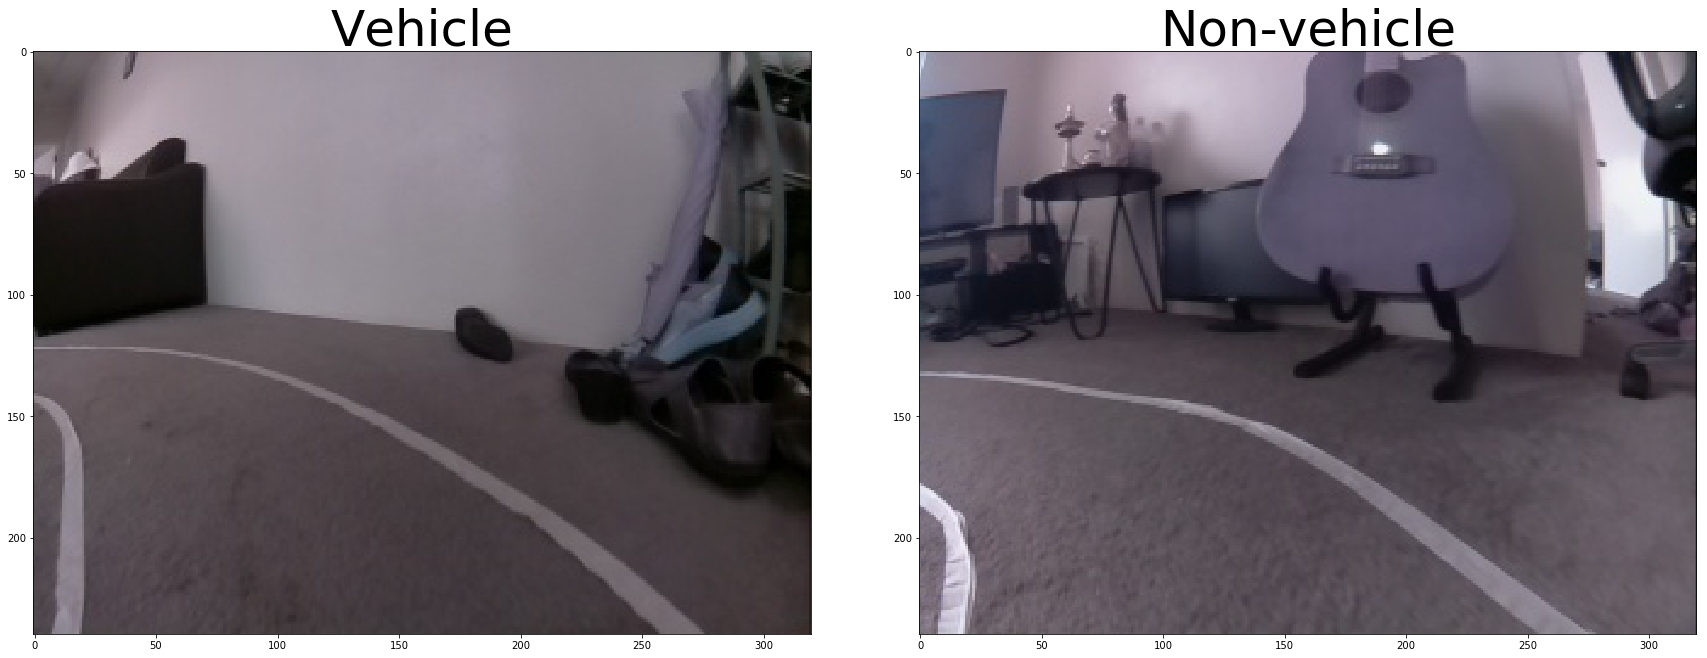

In [5]:
image1 = random.choice(vehicles)
# Getting brightnessed image
def brightnessed_img(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright = .25 + np.random.uniform()
    image[:,:,2] = image[:,:,2] * random_bright
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

    return image
image2 = random.choice(vehicles)#brightnessed_img(image1)
show_images(image1, "Vehicle", image2, "Non-vehicle")

In [6]:
from advanced_lane_helper_functions import *

In [7]:
nx = 9
ny = 6
objpoints = []
imgpoints = []
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

#Finding in mtx, dst
img = cv2.imread('camera_cal/calibration2.jpg')

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    imgpoints.append(corners)
    objpoints.append(objp)

    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [8]:

# Define a class to receive the characteristics of each line detection
class Lane():
    def __init__(self):
        self.last_left = None
        self.last_right = None
        self.left_fit = None
        self.right_fit = None
        self.counter = 0
        self.reset_counter = 0

In [9]:
def pipeline_advanced(img, lane, show_values=False):
    warped_img, left_fit, right_fit, M = find_lanes(img, mtx, dist, lane)
    left_curvature, right_curvature, center = radius_curvature(warped_img, left_fit, right_fit)
    
    return draw_on_image(img, warped_img, left_fit, right_fit, M, left_curvature, right_curvature, center, show_values)

In [10]:
lane = Lane()
def process_image_advanced(img):
    return pipeline_advanced(img, lane)

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    scaled_sobel = None
    
    # Sobel x
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        
    # Sobel y
    else:
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in y
        abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))

    # Threshold x gradient
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    magnitude = np.sqrt(np.square(sobelx)+np.square(sobely))
    abs_magnitude = np.absolute(magnitude)
    scaled_magnitude = np.uint8(255*abs_magnitude/np.max(abs_magnitude))
    mag_binary = np.zeros_like(scaled_magnitude)
    mag_binary[(scaled_magnitude >= mag_thresh[0]) & (scaled_magnitude <= mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(arctan)
    dir_binary[(arctan >= thresh[0]) & (arctan <= thresh[1])] = 1
    
    return dir_binary


def combined_s_gradient_thresholds(img, show=False):

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.4))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    if show == True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Actual image')
        ax1.imshow(img)
        ax2.set_title('Combined gradx,grady,magnitude,direction')
        #combined = cv2.cvtColor(combined, cv2.COLOR_GRAY2RGB)
        ax2.imshow(combined)
        
    return combined



(120, 320, 3)


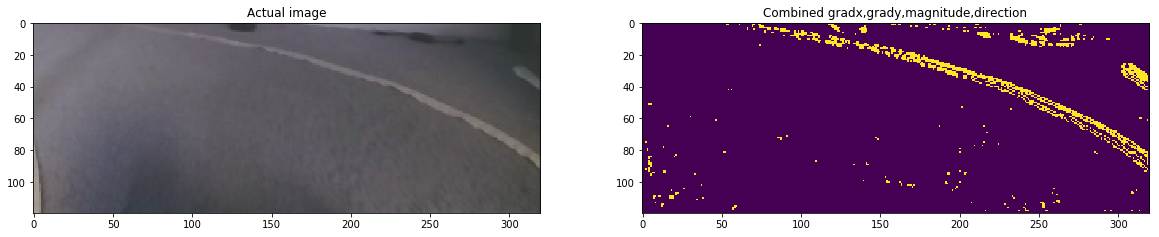

In [8]:
img = 'drive_data/training_data/folder1/image_1518037766651.jpg'
img = cv2.imread(img)
img = img[120:, :]
combined_binary = combined_s_gradient_thresholds(img, True)
print(img.shape)

In [3]:
img = 'drive_data/training_data_new/folder1/image_1517864588754.jpg'
img = cv2.imread(img)
img = img[100:, :]
combined_binary = combined_s_gradient_thresholds(img, True)

TypeError: 'NoneType' object is not subscriptable

In [4]:
img = 'drive_data/training_data_new/folder4/image_1517865183473.jpg'
img = cv2.imread(img)
img = img[100:, :]
combined_binary = combined_s_gradient_thresholds(img, True)

TypeError: 'NoneType' object is not subscriptable

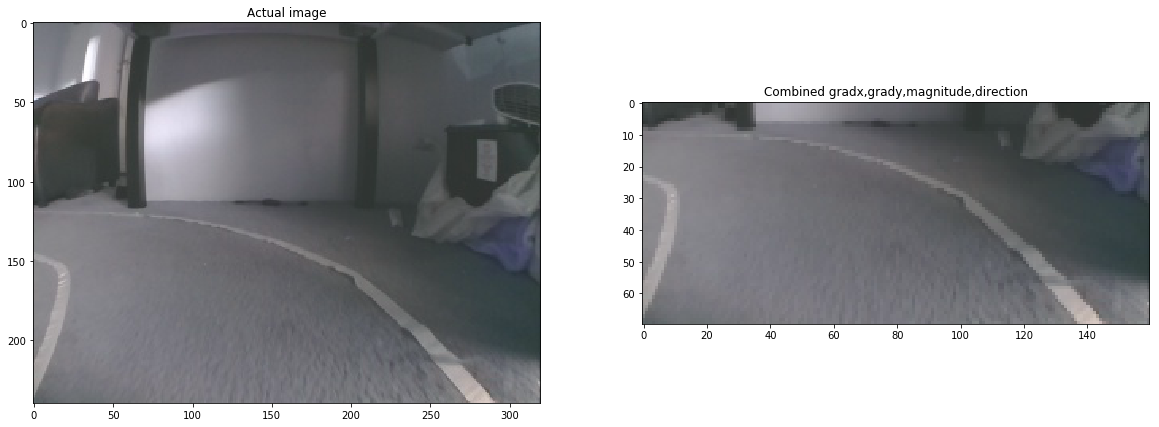

In [10]:
img = 'drive_data/training_data/folder1/image_1518595186783.jpg'
image = cv2.imread(img)
image1 = cv2.resize(image, (160, 120), interpolation=cv2.INTER_AREA)
image1 = image1[50:,:]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Actual image')
ax1.imshow(image)
ax2.set_title('Combined gradx,grady,magnitude,direction')
ax2.imshow(image1)
